In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import fastparquet
import gc
import cPickle as pickle

In [3]:
train_test=fastparquet.ParquetFile("../input/train_test.parq").to_pandas()

In [4]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  log_unit_sales
index                                                        
0         0         24         4           -1        2.080078
1         0         24         5           -1        0.693359
2         0         24         6           -1        1.098633
3         0         24        13           -1        0.693359
4         0         24        17           -1        0.693359

In [5]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128867504 entries, 0 to 3370463
Data columns (total 5 columns):
date              int16
store_nbr         int8
item_nbr          int16
onpromotion       int8
log_unit_sales    float32
dtypes: float32(1), int16(2), int8(2)
memory usage: 2.2 GB


In [6]:
stores_idx,items_idx,days_idx,states,cities,families,types = pickle.load(open("array_index.pkl"))

### trans target

In [7]:
item_perishable_map=pd.read_csv("../input/items.csv",index_col=0)['perishable'].to_dict()

In [8]:
perishable_item_map={v:item_perishable_map[k]  for k,v in items_idx.items()}

In [9]:
s=train_test['item_nbr'].map(perishable_item_map)

In [10]:
s.shape

(128867504,)

In [11]:
train_test['scaled_log_unit_sales']=(train_test['log_unit_sales']+(np.sqrt(1.25)-1)*s*train_test['log_unit_sales']).astype(np.float16)

In [12]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  log_unit_sales  \
index                                                           
0         0         24         4           -1        2.080078   
1         0         24         5           -1        0.693359   
2         0         24         6           -1        1.098633   
3         0         24        13           -1        0.693359   
4         0         24        17           -1        0.693359   

       scaled_log_unit_sales  
index                         
0                   2.326172  
1                   0.693359  
2                   1.098633  
3                   0.693359  
4                   0.775391

In [13]:
del s
gc.collect()

35198

In [14]:
train_test['scaled_log_unit_sales'].astype(np.float64).mean()

1.8088305281414505

In [15]:
train_test['scaled_log_unit_sales'].astype(np.float64).std()

0.9287268372598926

In [16]:
train_test['log_unit_sales'].astype(np.float64).mean()

1.7510193412229376

In [17]:
train_test['log_unit_sales'].astype(np.float64).std()

0.8815122465302372

In [18]:
train_test=train_test.drop("log_unit_sales",axis=1)

In [19]:
gc.collect()

38

### make y0

In [20]:
dim=[54, 4100, 1704]
np.prod(dim)

377265600

In [21]:
data=np.zeros(shape=dim,dtype=np.float16)

In [22]:
data.fill(np.nan)

In [23]:
data.nbytes/1024.**2

719.5770263671875

In [24]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['scaled_log_unit_sales'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [25]:
(np.isnan(values)).mean()

0.02615449120516837

In [26]:
np.mean(values)

nan

In [27]:
data[tuple(idxes)]=values

In [28]:
data[data>0]=1

In [29]:
(~np.isnan(data[:,:,:1688])).mean()

0.33580211236551544

In [30]:
data.shape

(54, 4100, 1704)

In [31]:
np.where(np.arange(10)>5)[0][0]

6

In [32]:
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        s=data[i,j]
        a=np.where(~np.isnan(s))[0]
        if len(a)>0:
            k= a[0]
            s2=s[k:1688]
            s2[np.isnan(s2)]=0
    print i,

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53


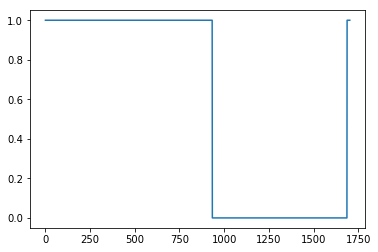

In [33]:
plt.plot(np.isnan(data[20,2123]));

In [34]:
data[:,:,[ 358,  723, 1088, 1454]]=np.nan

In [35]:
(~np.isnan(data[:,:,:1688])).mean()

0.52086798732323814

In [36]:
lst=[]
for i in range(1688):
    if i%20==0: print i,
    s=data[:,:,i]
    lst.append( [np.nanmean(s,dtype=np.float),np.sum(~np.isnan(s))])

0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340

/home/bo/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice


 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680


In [37]:
a=np.array(lst).T

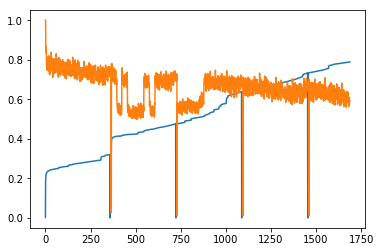

In [38]:
plt.plot(a[1]/54./4100);
plt.plot(a[0]);

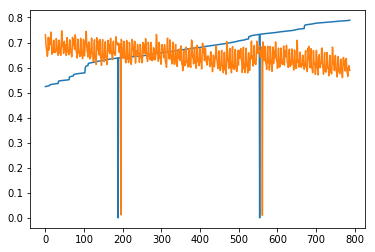

In [39]:
plt.plot(a[1][900:]/54./4100);
plt.plot(a[0][900:]);

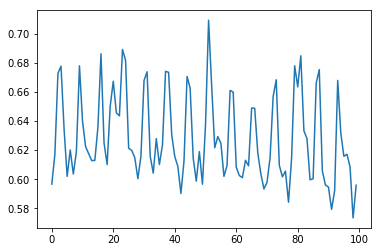

In [40]:
plt.plot(a[0][1500:1600]);

In [41]:
np.where(a[1]==0)

(array([ 358,  723, 1088, 1454]),)

In [42]:
1454+365,data.shape

(1819, (54, 4100, 1704))

In [43]:
np.diff([[ 358,  723, 1088, 1454]])

array([[365, 365, 366]])

In [44]:
data.shape

(54, 4100, 1704)

In [45]:
data.dtype

dtype('float16')

In [46]:
np.savez_compressed("../input/s4/y_0", data)

In [47]:
gc.collect()

18008

In [48]:
npzfile = np.load("../input/s4/y_0.npz")

In [49]:
npzfile.files

['arr_0']

In [50]:
train_test.head()

date  store_nbr  item_nbr  onpromotion  scaled_log_unit_sales
index                                                               
0         0         24         4           -1               2.326172
1         0         24         5           -1               0.693359
2         0         24         6           -1               1.098633
3         0         24        13           -1               0.693359
4         0         24        17           -1               0.775391

### make onpromotion

In [51]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.empty(shape=dim,dtype=np.float16)
data.fill(np.nan)

377265600


In [52]:
data.nbytes/1024.**2

719.5770263671875

In [53]:
idxes=train_test[['store_nbr','item_nbr','date']].values.T
values=train_test['onpromotion'].values
idxes.shape,values.shape

((3, 128867504), (128867504,))

In [54]:
(~np.isnan(values)).sum()

128867504

In [55]:
data[tuple(idxes)]=values

In [56]:
(~np.isnan(data)).sum()

128867504

In [57]:
np.nanmean(data.astype(np.float64))

-0.10591057928770002

In [58]:
np.savez_compressed("../input/s4/onpromotion_0", data)

In [59]:
gc.collect()

279

### holiday

In [60]:
stores=pd.read_csv("../input/stores.csv")
stores['store_nbr']=stores['store_nbr'].map(lambda u: stores_idx[u])

In [61]:
stores.head()

store_nbr           city                           state type  cluster
0          0          Quito                       Pichincha    D       13
1          1          Quito                       Pichincha    D       13
2          2          Quito                       Pichincha    D        8
3          3          Quito                       Pichincha    D        9
4          4  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [62]:
end_date =pd.to_datetime('2017-08-31')
start_date=pd.to_datetime('2013-01-01')

In [63]:
holiday=pd.read_csv("../input/holidays_events.csv", parse_dates=['date'], date_parser=lambda x: pd.datetime.strptime(x, '%Y-%m-%d'))

In [64]:
holiday=holiday[holiday['date']>=start_date]
holiday=holiday[holiday['date']<=end_date]
holiday.shape

(287, 6)

In [65]:
holiday['date']=holiday['date'].map(lambda u: days_idx[u])

In [66]:
dim=[54, 4100, 1704]
print np.prod(dim)
data=np.ones(shape=dim,dtype=np.float16)
data.fill(np.nan)
print data.nbytes/1024.**2

377265600
719.577026367


In [67]:
country_holiday=holiday[holiday['locale']=='National']
print country_holiday.shape
country_holiday.head()

(151, 6)


date      type    locale locale_name                         description  \
41     0   Holiday  National     Ecuador                  Primer dia del ano   
42     4  Work Day  National     Ecuador             Recupero puente Navidad   
43    11  Work Day  National     Ecuador  Recupero puente primer dia del ano   
44    41   Holiday  National     Ecuador                            Carnaval   
45    42   Holiday  National     Ecuador                            Carnaval   

    transferred  
41        False  
42        False  
43        False  
44        False  
45        False

In [68]:
data[:,:,country_holiday['date'].values]=1

In [69]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.086267605633802813

In [70]:
state_holiday=holiday[holiday['locale']=='Regional']
print state_holiday.shape
state_holiday.head()

(18, 6)


date     type    locale                     locale_name  \
47    90  Holiday  Regional                        Cotopaxi   
58   175  Holiday  Regional                        Imbabura   
76   309  Holiday  Regional  Santo Domingo de los Tsachilas   
77   310  Holiday  Regional                     Santa Elena   
96   455  Holiday  Regional                        Cotopaxi   

                           description  transferred  
47       Provincializacion de Cotopaxi        False  
58       Provincializacion de Imbabura        False  
76  Provincializacion de Santo Domingo        False  
77       Provincializacion Santa Elena        False  
96       Provincializacion de Cotopaxi        False

In [71]:
state_holiday=pd.merge(state_holiday,stores, left_on='locale_name', right_on="state")

In [72]:
print state_holiday.isnull().sum().sum(),state_holiday.shape
state_holiday.head()

0 (31, 11)


date   type_x    locale locale_name                    description  \
0    90  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
1    90  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2   455  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
3   455  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
4   820  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   

   transferred  store_nbr       city     state type_y  cluster  
0        False         11  Latacunga  Cotopaxi      C       15  
1        False         12  Latacunga  Cotopaxi      C       15  
2        False         11  Latacunga  Cotopaxi      C       15  
3        False         12  Latacunga  Cotopaxi      C       15  
4        False         11  Latacunga  Cotopaxi      C       15

In [73]:
data[state_holiday['store_nbr'].values,:,state_holiday['date'].values]=1

In [74]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.086593635889410533

In [75]:
locale_holiday=holiday[holiday['locale']=='Local']
print locale_holiday.shape
locale_holiday.head()

(118, 6)


date     type locale locale_name                description  transferred
46    60  Holiday  Local       Manta         Fundacion de Manta        False
48   101  Holiday  Local      Cuenca        Fundacion de Cuenca        False
49   103  Holiday  Local    Libertad  Cantonizacion de Libertad        False
50   110  Holiday  Local    Riobamba  Cantonizacion de Riobamba        False
54   131  Holiday  Local        Puyo     Cantonizacion del Puyo        False

In [76]:
locale_holiday=pd.merge(locale_holiday,stores, left_on='locale_name', right_on="city")

In [77]:
print locale_holiday.isnull().sum().sum(),locale_holiday.shape
locale_holiday.head()

0 (381, 11)


date   type_x locale locale_name         description  transferred  \
0    60  Holiday  Local       Manta  Fundacion de Manta        False   
1    60  Holiday  Local       Manta  Fundacion de Manta        False   
2   425  Holiday  Local       Manta  Fundacion de Manta        False   
3   425  Holiday  Local       Manta  Fundacion de Manta        False   
4   790  Holiday  Local       Manta  Fundacion de Manta        False   

   store_nbr   city   state type_y  cluster  
0         51  Manta  Manabi      A       11  
1         52  Manta  Manabi      D       13  
2         51  Manta  Manabi      A       11  
3         52  Manta  Manabi      D       13  
4         51  Manta  Manabi      A       11

In [78]:
data[locale_holiday['store_nbr'].values,:,locale_holiday['date'].values]=1

In [79]:
np.nansum(data.astype(np.float64))/prod(data.shape)

0.090495131281516261

In [80]:
data.shape,data.dtype

((54, 4100, 1704), dtype('float16'))

In [81]:
data.nbytes/1024.**2

719.5770263671875

In [82]:
np.savez_compressed("../input/s4/holiday_0", data)

In [83]:
import gc
gc.collect()

370